https://langchain-ai.github.io/langgraph/how-tos/human_in_the_loop/add-human-in-the-loop/

### Pause using interrupt

In [2]:
from typing import TypedDict
import uuid
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.constants import START
from langgraph.graph import StateGraph

from langgraph.types import interrupt, Command


class State(TypedDict):
    some_text: str


def human_node(state: State):
    value = interrupt(  
        {
            "text_to_revise": state["some_text"]  
        }
    )
    return {
        "some_text": value  
    }


# Build the graph
graph_builder = StateGraph(State)
graph_builder.add_node("human_node", human_node)
graph_builder.add_edge(START, "human_node")
checkpointer = InMemorySaver()  
graph = graph_builder.compile(checkpointer=checkpointer)
# Pass a thread ID to the graph to run it.
config = {"configurable": {"thread_id": uuid.uuid4()}}
# Run the graph until the interrupt is hit.
result = graph.invoke({"some_text": "original text"}, config=config)  

print(result['__interrupt__']) 

[Interrupt(value={'text_to_revise': 'original text'}, id='73185367ad66b1e1fd74ed44b257b749')]


In [3]:
print(graph.invoke(Command(resume="Edited text"), config=config)) 

{'some_text': 'Edited text'}


## Resume multiple interrupts with one invocation

In [6]:
from typing import TypedDict
import uuid
from langchain_core.runnables import RunnableConfig
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.constants import START
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command


class State(TypedDict):
    text_1: str
    text_2: str


def human_node_1(state: State):
    value = interrupt({"text_to_revise": state["text_1"]})
    return {"text_1": value}


def human_node_2(state: State):
    value = interrupt({"text_to_revise": state["text_2"]})
    return {"text_2": value}


graph_builder = StateGraph(State)
graph_builder.add_node("human_node_1", human_node_1)
graph_builder.add_node("human_node_2", human_node_2)

# Add both nodes in parallel from START
graph_builder.add_edge(START, "human_node_1")
graph_builder.add_edge(START, "human_node_2")

checkpointer = InMemorySaver()
graph = graph_builder.compile(checkpointer=checkpointer)

thread_id = str(uuid.uuid4())
config: RunnableConfig = {"configurable": {"thread_id": thread_id}}
result = graph.invoke(
    {"text_1": "original text 1", "text_2": "original text 2"}, config=config
)

# Resume with mapping of interrupt IDs to values
resume_map = {
    i.id: f"human input for prompt {i.value}"
    for i in graph.get_state(config).interrupts
}
print(graph.invoke(Command(resume=resume_map), config=config))
# > {'text_1': 'edited text for original text 1', 'text_2': 'edited text for original text 2'}

{'text_1': "human input for prompt {'text_to_revise': 'original text 1'}", 'text_2': "human input for prompt {'text_to_revise': 'original text 2'}"}


## Approve or reject

In [12]:
from typing import Literal, TypedDict
import uuid

from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import InMemorySaver

# Define the shared graph state
class State(TypedDict):
    llm_output: str
    decision: str

# Simulate an LLM output node
def generate_llm_output(state: State) -> State:
    return {"llm_output": "This is the generated output."}

# Human approval node
def human_approval(state: State) -> Command[Literal["approved_path", "rejected_path"]]:
    decision = interrupt({
        "question": "Do you approve the following output?",
        "llm_output": state["llm_output"]
    })

    if decision == "approve":
        return Command(goto="approved_path", update={"decision": "approved"})
    else:
        return Command(goto="rejected_path", update={"decision": "rejected"})

# Next steps after approval
def approved_node(state: State) -> State:
    print("✅ Approved path taken.")
    return state

# Alternative path after rejection
def rejected_node(state: State) -> State:
    print("❌ Rejected path taken.")
    return state

# Build the graph
builder = StateGraph(State)
builder.add_node("generate_llm_output", generate_llm_output)
builder.add_node("human_approval", human_approval)
builder.add_node("approved_path", approved_node)
builder.add_node("rejected_path", rejected_node)

builder.set_entry_point("generate_llm_output")
builder.add_edge("generate_llm_output", "human_approval")
builder.add_edge("approved_path", END)
builder.add_edge("rejected_path", END)

checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

# Run until interrupt
config = {"configurable": {"thread_id": uuid.uuid4()}}
result = graph.invoke({}, config=config)
print(result["__interrupt__"])

[Interrupt(value={'question': 'Do you approve the following output?', 'llm_output': 'This is the generated output.'}, id='a309f3321f9183bd5c5628734d980989')]


In [13]:
# Simulate resuming with human input
# To test rejection, replace resume="approve" with resume="reject"
final_result = graph.invoke(Command(resume="approve"), config=config)
print(final_result)

✅ Approved path taken.
{'llm_output': 'This is the generated output.', 'decision': 'approved'}


## Review and edit state

In [14]:
from typing import TypedDict
import uuid

from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import InMemorySaver

# Define the graph state
class State(TypedDict):
    summary: str

# Simulate an LLM summary generation
def generate_summary(state: State) -> State:
    return {
        "summary": "The cat sat on the mat and looked at the stars."
    }

# Human editing node
def human_review_edit(state: State) -> State:
    result = interrupt({
        "task": "Please review and edit the generated summary if necessary.",
        "generated_summary": state["summary"]
    })
    return {
        "summary": result["edited_summary"]
    }

# Simulate downstream use of the edited summary
def downstream_use(state: State) -> State:
    print(f"✅ Using edited summary: {state['summary']}")
    return state

# Build the graph
builder = StateGraph(State)
builder.add_node("generate_summary", generate_summary)
builder.add_node("human_review_edit", human_review_edit)
builder.add_node("downstream_use", downstream_use)

builder.set_entry_point("generate_summary")
builder.add_edge("generate_summary", "human_review_edit")
builder.add_edge("human_review_edit", "downstream_use")
builder.add_edge("downstream_use", END)

# Set up in-memory checkpointing for interrupt support
checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

# Invoke the graph until it hits the interrupt
config = {"configurable": {"thread_id": uuid.uuid4()}}
result = graph.invoke({}, config=config)

# Output interrupt payload
print(result["__interrupt__"])

[Interrupt(value={'task': 'Please review and edit the generated summary if necessary.', 'generated_summary': 'The cat sat on the mat and looked at the stars.'}, id='addafbcff7a8750bdc31ab8416185104')]


In [15]:
# Resume the graph with human-edited input
edited_summary = "The cat lay on the rug, gazing peacefully at the night sky."
resumed_result = graph.invoke(
    Command(resume={"edited_summary": edited_summary}),
    config=config
)
print(resumed_result)

✅ Using edited summary: The cat lay on the rug, gazing peacefully at the night sky.
{'summary': 'The cat lay on the rug, gazing peacefully at the night sky.'}


## Review tool calls

In [16]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.types import interrupt
from langgraph.prebuilt import create_react_agent

# An example of a sensitive tool that requires human review / approval
def book_hotel(hotel_name: str):
    """Book a hotel"""
    response = interrupt(  
        f"Trying to call `book_hotel` with args {{'hotel_name': {hotel_name}}}. "
        "Please approve or suggest edits."
    )
    if response["type"] == "accept":
        pass
    elif response["type"] == "edit":
        hotel_name = response["args"]["hotel_name"]
    else:
        raise ValueError(f"Unknown response type: {response['type']}")
    return f"Successfully booked a stay at {hotel_name}."

checkpointer = InMemorySaver() 

agent = create_react_agent(
    model="openai:gpt-4o-mini",
    tools=[book_hotel],
    checkpointer=checkpointer, 
)

In [17]:
config = {
   "configurable": {
      "thread_id": "1"
   }
}

for chunk in agent.stream(
    {"messages": [{"role": "user", "content": "book a stay at McKittrick hotel"}]},
    config
):
    print(chunk)
    print("\n")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_IsR0GOV5Nxavzk3RaKjYmWB5', 'function': {'arguments': '{"hotel_name":"McKittrick Hotel"}', 'name': 'book_hotel'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 52, 'total_tokens': 72, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_51db84afab', 'id': 'chatcmpl-C7GGeJPWr5WiSQ6AAoiuhlbBXOQVb', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--8db0d6c1-fb1d-48ff-980c-2baa64889611-0', tool_calls=[{'name': 'book_hotel', 'args': {'hotel_name': 'McKittrick Hotel'}, 'id': 'call_IsR0GOV5Nxavzk3RaKjYmWB5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 52, 'output_tokens':

In [18]:
from langgraph.types import Command

for chunk in agent.stream(
    Command(resume={"type": "accept"}),  
    # Command(resume={"type": "edit", "args": {"hotel_name": "McKittrick Hotel"}}),
    config
):
    print(chunk)
    print("\n")

{'tools': {'messages': [ToolMessage(content='Successfully booked a stay at McKittrick Hotel.', name='book_hotel', id='ec2267c1-5ec1-4e64-9c47-35124365627c', tool_call_id='call_IsR0GOV5Nxavzk3RaKjYmWB5')]}}


{'agent': {'messages': [AIMessage(content='Your stay at the McKittrick Hotel has been successfully booked! Enjoy your time there!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 92, 'total_tokens': 112, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C7GHVIoAdN2FzWbj1BrVtyiWImh9F', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--1d3e1239-d400-4b8e-9590-8c20e3319a21-0', usage_metadata={'input_tokens': 92, 'output_tokens': 20, 'total_tok

## Add interrupts to any tool

In [19]:
from typing import Callable
from langchain_core.tools import BaseTool, tool as create_tool
from langchain_core.runnables import RunnableConfig
from langgraph.types import interrupt
from langgraph.prebuilt.interrupt import HumanInterruptConfig, HumanInterrupt

def add_human_in_the_loop(
    tool: Callable | BaseTool,
    *,
    interrupt_config: HumanInterruptConfig = None,
) -> BaseTool:
    """Wrap a tool to support human-in-the-loop review."""
    if not isinstance(tool, BaseTool):
        tool = create_tool(tool)

    if interrupt_config is None:
        interrupt_config = {
            "allow_accept": True,
            "allow_edit": True,
            "allow_respond": True,
        }

    @create_tool(  
        tool.name,
        description=tool.description,
        args_schema=tool.args_schema
    )
    def call_tool_with_interrupt(config: RunnableConfig, **tool_input):
        request: HumanInterrupt = {
            "action_request": {
                "action": tool.name,
                "args": tool_input
            },
            "config": interrupt_config,
            "description": "Please review the tool call"
        }
        response = interrupt([request])[0]  
        # approve the tool call
        if response["type"] == "accept":
            tool_response = tool.invoke(tool_input, config)
        # update tool call args
        elif response["type"] == "edit":
            tool_input = response["args"]["args"]
            tool_response = tool.invoke(tool_input, config)
        # respond to the LLM with user feedback
        elif response["type"] == "response":
            user_feedback = response["args"]
            tool_response = user_feedback
        else:
            raise ValueError(f"Unsupported interrupt response type: {response['type']}")

        return tool_response

    return call_tool_with_interrupt

In [20]:
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.prebuilt import create_react_agent

checkpointer = InMemorySaver()

def book_hotel(hotel_name: str):
   """Book a hotel"""
   return f"Successfully booked a stay at {hotel_name}."


agent = create_react_agent(
    model="openai:gpt-4o-mini",
    tools=[
        add_human_in_the_loop(book_hotel), 
    ],
    checkpointer=checkpointer,
)

config = {"configurable": {"thread_id": "1"}}

# Run the agent
for chunk in agent.stream(
    {"messages": [{"role": "user", "content": "book a stay at McKittrick hotel"}]},
    config
):
    print(chunk)
    print("\n")

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_nVd3b44IfcPf2N8kyvnAgf6D', 'function': {'arguments': '{"hotel_name":"McKittrick hotel"}', 'name': 'book_hotel'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 52, 'total_tokens': 72, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C7GJzQVdMhBVwELPziGnOyLtqzqGB', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--b54a0e64-35aa-487b-8c8b-1c31fd014f64-0', tool_calls=[{'name': 'book_hotel', 'args': {'hotel_name': 'McKittrick hotel'}, 'id': 'call_nVd3b44IfcPf2N8kyvnAgf6D', 'type': 'tool_call'}], usage_metadata={'input_tokens': 52, 'output_tokens':

In [21]:
from langgraph.types import Command

for chunk in agent.stream(
    # Command(resume=[{"type": "accept"}]),
    Command(resume=[{"type": "edit", "args": {"args": {"hotel_name": "Wawa Hotel"}}}]),
    config
):
    print(chunk)
    print("\n")

{'tools': {'messages': [ToolMessage(content='Successfully booked a stay at Wawa Hotel.', name='book_hotel', id='5e31ea12-f6f3-45ea-92b3-4a9d35c402a0', tool_call_id='call_nVd3b44IfcPf2N8kyvnAgf6D')]}}


{'agent': {'messages': [AIMessage(content='Your stay at the McKittrick Hotel has been successfully booked. Enjoy your stay!', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 90, 'total_tokens': 109, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C7GKRSMPWd5VrKP32RSe0JJBSvW6r', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--470ad54e-64ef-4a1d-8650-0987cd9ff1bc-0', usage_metadata={'input_tokens': 90, 'output_tokens': 19, 'total_tokens': 109, '

## Validate human input

In [22]:
from typing import TypedDict
import uuid

from langgraph.constants import START, END
from langgraph.graph import StateGraph
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import InMemorySaver

# Define graph state
class State(TypedDict):
    age: int

# Node that asks for human input and validates it
def get_valid_age(state: State) -> State:
    prompt = "Please enter your age (must be a non-negative integer)."

    while True:
        user_input = interrupt(prompt)

        # Validate the input
        try:
            age = int(user_input)
            if age < 0:
                raise ValueError("Age must be non-negative.")
            break  # Valid input received
        except (ValueError, TypeError):
            prompt = f"'{user_input}' is not valid. Please enter a non-negative integer for age."

    return {"age": age}

# Node that uses the valid input
def report_age(state: State) -> State:
    print(f"✅ Human is {state['age']} years old.")
    return state

# Build the graph
builder = StateGraph(State)
builder.add_node("get_valid_age", get_valid_age)
builder.add_node("report_age", report_age)

builder.set_entry_point("get_valid_age")
builder.add_edge("get_valid_age", "report_age")
builder.add_edge("report_age", END)

# Create the graph with a memory checkpointer
checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

# Run the graph until the first interrupt
config = {"configurable": {"thread_id": uuid.uuid4()}}
result = graph.invoke({}, config=config)
print(result["__interrupt__"])  # First prompt: "Please enter your age..."

[Interrupt(value='Please enter your age (must be a non-negative integer).', id='a9319cc883924ef592d7094980606f9e')]


In [23]:
# Simulate an invalid input (e.g., string instead of integer)
result = graph.invoke(Command(resume="not a number"), config=config)
print(result["__interrupt__"])  # Follow-up prompt with validation message

[Interrupt(value="'not a number' is not valid. Please enter a non-negative integer for age.", id='a9319cc883924ef592d7094980606f9e')]


In [24]:
# Simulate a second invalid input (e.g., negative number)
result = graph.invoke(Command(resume="-10"), config=config)
print(result["__interrupt__"])  # Another retry

[Interrupt(value="'-10' is not valid. Please enter a non-negative integer for age.", id='a9319cc883924ef592d7094980606f9e')]


In [25]:
# Provide valid input
final_result = graph.invoke(Command(resume="25"), config=config)
print(final_result)  # Should include the valid age

✅ Human is 25 years old.
{'age': 25}


## Debug with interrupts

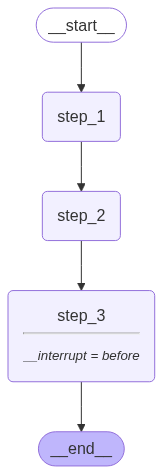

{'input': 'hello world'}
---Step 1---
---Step 2---


In [26]:
from IPython.display import Image, display
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import InMemorySaver
from langgraph.graph import StateGraph, START, END


class State(TypedDict):
    input: str


def step_1(state):
    print("---Step 1---")
    pass


def step_2(state):
    print("---Step 2---")
    pass


def step_3(state):
    print("---Step 3---")
    pass


builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("step_2", step_2)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "step_2")
builder.add_edge("step_2", "step_3")
builder.add_edge("step_3", END)

# Set up a checkpointer
checkpointer = InMemorySaver() # (1)!

graph = builder.compile(
    checkpointer=checkpointer, # (2)!
    interrupt_before=["step_3"] # (3)!
)

# View
display(Image(graph.get_graph().draw_mermaid_png()))


# Input
initial_input = {"input": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

In [27]:
# This will run until the breakpoint
# You can get the state of the graph at this point
print(graph.get_state(config))

StateSnapshot(values={}, next=(), config={'configurable': {'thread_id': '86bf5e5c-cf45-47fe-a3eb-1434b4fc947a'}}, metadata=None, created_at=None, parent_config=None, tasks=(), interrupts=())


In [28]:
# You can continue the graph execution by passing in `None` for the input
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 3---


## Using with subgraphs called as functions

In [29]:
import uuid
from typing import TypedDict

from langgraph.graph import StateGraph
from langgraph.constants import START
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import InMemorySaver


class State(TypedDict):
    """The graph state."""
    state_counter: int


counter_node_in_subgraph = 0

def node_in_subgraph(state: State):
    """A node in the sub-graph."""
    global counter_node_in_subgraph
    counter_node_in_subgraph += 1  # This code will **NOT** run again!
    print(f"Entered `node_in_subgraph` a total of {counter_node_in_subgraph} times")

counter_human_node = 0

def human_node(state: State):
    global counter_human_node
    counter_human_node += 1 # This code will run again!
    print(f"Entered human_node in sub-graph a total of {counter_human_node} times")
    answer = interrupt("what is your name?")
    print(f"Got an answer of {answer}")


checkpointer = InMemorySaver()

subgraph_builder = StateGraph(State)
subgraph_builder.add_node("some_node", node_in_subgraph)
subgraph_builder.add_node("human_node", human_node)
subgraph_builder.add_edge(START, "some_node")
subgraph_builder.add_edge("some_node", "human_node")
subgraph = subgraph_builder.compile(checkpointer=checkpointer)


counter_parent_node = 0

def parent_node(state: State):
    """This parent node will invoke the subgraph."""
    global counter_parent_node

    counter_parent_node += 1 # This code will run again on resuming!
    print(f"Entered `parent_node` a total of {counter_parent_node} times")

    # Please note that we're intentionally incrementing the state counter
    # in the graph state as well to demonstrate that the subgraph update
    # of the same key will not conflict with the parent graph (until
    subgraph_state = subgraph.invoke(state)
    return subgraph_state


builder = StateGraph(State)
builder.add_node("parent_node", parent_node)
builder.add_edge(START, "parent_node")

# A checkpointer must be enabled for interrupts to work!
checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

config = {
    "configurable": {
      "thread_id": uuid.uuid4(),
    }
}

for chunk in graph.stream({"state_counter": 1}, config):
    print(chunk)

Entered `parent_node` a total of 1 times
Entered `node_in_subgraph` a total of 1 times
Entered human_node in sub-graph a total of 1 times
{'__interrupt__': (Interrupt(value='what is your name?', id='46584010e242b4dddca8df0d2856fba0'),)}


In [30]:
print('--- Resuming ---')

for chunk in graph.stream(Command(resume="35"), config):
    print(chunk)

--- Resuming ---
Entered `parent_node` a total of 2 times
Entered human_node in sub-graph a total of 2 times
Got an answer of 35
{'parent_node': {'state_counter': 1}}


## Using multiple interrupts in a single node

In [46]:
import uuid
from typing import TypedDict, Optional

from langgraph.graph import StateGraph
from langgraph.constants import START
from langgraph.types import interrupt, Command
from langgraph.checkpoint.memory import InMemorySaver


class State(TypedDict):
    """The graph state."""
    name: Optional[str]
    age: Optional[str]


def human_node(state: State):
    if not state.get('name'):
        name = interrupt("what is your name?")
    else:
        name = "N/A"

    if not state.get('age'):
        age = interrupt("what is your age?")
    else:
        age = "N/A"

    print(f"Name: {name}. Age: {age}")

    return {
        "age": age,
        "name": name,
    }


builder = StateGraph(State)
builder.add_node("human_node", human_node)
builder.add_edge(START, "human_node")

# A checkpointer must be enabled for interrupts to work!
checkpointer = InMemorySaver()
graph = builder.compile(checkpointer=checkpointer)

config = {
    "configurable": {
        "thread_id": uuid.uuid4(),
    }
}

for chunk in graph.stream({"age": None, "name": None}, config):
    print(chunk)

{'__interrupt__': (Interrupt(value='what is your name?', id='a19223351a6e2443e4e7f35ff7ed7450'),)}


In [47]:
for chunk in graph.stream(Command(resume="aaa"), config):
    print(chunk)

{'__interrupt__': (Interrupt(value='what is your age?', id='a19223351a6e2443e4e7f35ff7ed7450'),)}


In [48]:
for chunk in graph.stream(Command(resume=15), config):
    print(chunk)

Name: aaa. Age: 15
{'human_node': {'age': 15, 'name': 'aaa'}}
